### Protein Family Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

from lazy import lazy
from attrdict import AttrDict

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.manifold import TSNE

In [2]:
import pickle

NUM_EMBED = 100

with open('embedding.pickle', 'rb') as f:
    codons_embedding = pickle.load(f)
    
def protein_to_features(line, n=3):
    codons = [line[n * i : n * i + n] for i in range(0, len(line) // n)]
    return np.array([codons_embedding[key if key in codons_embedding else '<unk>'] for key in codons])

In [3]:
family_classification_metadata = pd.read_table('data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('data/family_classification_sequences.tab')

In [4]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [6]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_TBEVH,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [7]:
most_frequent = family_classification_metadata['FamilyID'].value_counts()[:2]
index = family_classification_metadata['FamilyID'].isin(most_frequent.index)
classes = np.array(family_classification_metadata['FamilyID'][index])

In [8]:
def vectorize_protein(X):
    return np.array([sample.sum(axis=0) for sample in X])

In [9]:
X = vectorize_protein([protein_to_features(line[0]) for line in np.array(family_classification_sequences[index])])

In [10]:
tsne = TSNE(n_components=2, random_state=0)
XX = tsne.fit_transform(X)

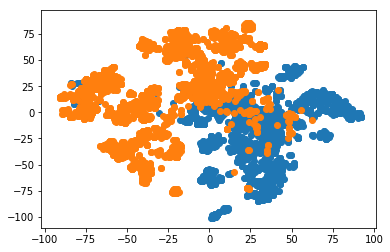

In [11]:
for cl in np.unique(classes):
    X_cl = XX[classes == cl]
    plt.scatter(X_cl[:, 0], X_cl[:, 1])

In [12]:
NUM_CLASSES = 1000

In [13]:
most_frequent = family_classification_metadata['FamilyID'].value_counts()[:NUM_CLASSES]
index = family_classification_metadata['FamilyID'].isin(most_frequent.index)
classes = np.array(family_classification_metadata['FamilyID'][index])

lb = LabelBinarizer()
lb.fit(classes)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [14]:
y = lb.transform(classes)
y.shape # one-hot-encoded labels

(261149, 1000)

In [15]:
def get_labels(y):
    return np.argmax(y, axis=1)

In [16]:
X = [protein_to_features(line[0]) for line in np.array(family_classification_sequences[index])]
len(X), X[0].shape # samples in format [n_codones, embed_size]

(261149, (316, 100))

In [17]:
sss = StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2)

for train_index, test_index in sss.split(X, classes):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = y[train_index], y[test_index]

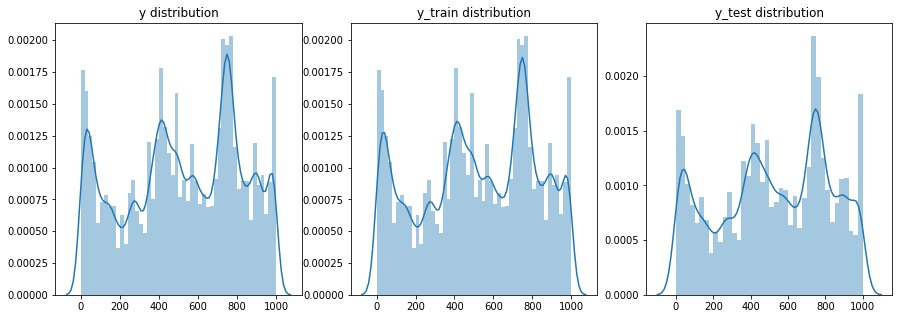

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].set_title('y distribution')
axs[1].set_title('y_train distribution')
axs[2].set_title('y_test distribution')
sns.distplot(get_labels(y), ax=axs[0])
sns.distplot(get_labels(y_train), ax=axs[1])
sns.distplot(get_labels(y_test), ax=axs[2])

In [85]:
svm_X_train = vectorize_protein(X_train)
scaling = StandardScaler().fit(svm_X_train)
svm_X_train = scaling.transform(svm_X_train)
svm_X_test = scaling.transform(vectorize_protein(X_test))

In [ ]:
clf = svm.SVC(max_iter=1, random_state=0)
clf.fit(svm_X_train, get_labels(y_train))
svm_prediction = clf.predict(svm_X_test)
print('Achieved accuracy via SVM: {}'.format((svm_prediction == get_labels(y_test)).sum() / len(y_test)))

In [19]:
class Embedding:
    def __init__(self, length):
        self._length = length
        self.dimensions = NUM_EMBED
        
    def __call__(self, sample):
        data = np.zeros((self._length, self.dimensions))
        data[:len(sample)] = sample
        return data

In [20]:
length = max(len(sample) for sample in X)
embedding = Embedding(length)

In [21]:
params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden= 2 * NUM_EMBED,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    batch_size=20,
    gradient_clipping=100,
    seq_length=length,
    embed_length=embedding.dimensions
)

In [22]:
def preprocess_batched(X, y, length, embedding, batch_size):
    iterator = iter(zip(X, y))
    while True:
        data = np.zeros((batch_size, length, embedding.dimensions))
        target = np.zeros((batch_size, NUM_CLASSES))
        for index in range(batch_size):
            text, label = next(iterator)
            data[index] = embedding(text)
            target[index] = label
        yield data, target

In [23]:
batches = preprocess_batched(X_train, y_train, length, embedding, params.batch_size)

In [24]:
class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('error', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [ ]:
tf.reset_default_graph()
model = SequenceClassificationModel(params)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    for index, batch in enumerate(batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print('{}: {:3.1f}%'.format(index + 1, 100 * error))
        if index % 100 == 0:
            summary_writer.add_summary(summary_str, index)

1: 100.0%
2: 100.0%
3: 100.0%
4: 100.0%
5: 100.0%
6: 100.0%
7: 100.0%
8: 100.0%
9: 100.0%
10: 100.0%
11: 100.0%
12: 100.0%
13: 100.0%
14: 100.0%
15: 100.0%
16: 95.0%
17: 100.0%
18: 100.0%
19: 100.0%
20: 100.0%
21: 100.0%
22: 100.0%
23: 100.0%
24: 100.0%
25: 100.0%
26: 100.0%


In [80]:
test_batches = preprocess_batched(X_test, y_test, length, embedding, params.batch_size)

In [71]:
def check_top_n(prediction, target, n=5):
    ind = np.argsort(prediction, axis=1)[:, -n:]
    classes = np.argmax(batch[1], axis=1)
    accuracy = 0
    for i, cl in enumerate(classes):
        if cl in ind[i]:
            accuracy += 1
    return accuracy / len(prediction)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    mean_accuracy = 0
    for index, batch in enumerate(test_batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        prediction = sess.run(model.prediction, feed)
        curr_accuracy = check_top_n(prediction, batch[1], 10)
        mean_accuracy += curr_accuracy
        print('{}: {:3.1f}%'.format(index + 1, 100 * curr_accuracy))

1: 0.0%
2: 10.0%
3: 0.0%
4: 0.0%
5: 0.0%
6: 0.0%
7: 5.0%
8: 10.0%
9: 0.0%
10: 0.0%
11: 0.0%
12: 0.0%
13: 0.0%
14: 0.0%
15: 0.0%
16: 0.0%
17: 0.0%
18: 0.0%
19: 5.0%
20: 0.0%
21: 5.0%
22: 0.0%
23: 0.0%
24: 10.0%
25: 0.0%
26: 0.0%
27: 0.0%
28: 5.0%
29: 0.0%
30: 0.0%
31: 0.0%
32: 0.0%
33: 0.0%
34: 0.0%


In [87]:
print('Achieved accuracy via RNN: {}'.format(mean_accuracy / (index + 1)))

Achieved accuracy via RNN: 0.01120260436614333
